**Optimize geometry of H2O**

Follows Pennylane adaptive circuit tutorial to obtain circuit, and molecular geometry tutorial to optimize geometry

In [1]:
import psi4

In [2]:
from pennylane import numpy as np
import pennylane as qml

In [3]:
from pennylane import qchem

In [4]:
from openfermion.chem import MolecularData
from openfermionpsi4 import run_psi4

In [5]:
ang_coords = np.array([0.0000,0.7581,-0.5086,
                       0.0,0.0,0.1272,
                       0.0000,-0.7581,-0.5086])

bohr_angs = 0.529177210903
angs_bohr = 1/bohr_angs

In [6]:
# Set up the molecule. Geometry coordinates from CCCBDB

symbols = ["H","O","H"]
geometry = np.array(ang_coords*angs_bohr, requires_grad=True)
print(geometry)

[ 0.          1.43260138 -0.96111471  0.          0.          0.24037316
  0.         -1.43260138 -0.96111471]


Now create the circuit using https://pennylane.ai/qml/demos/tutorial_adaptive_circuits.html

First - compute the Hamiltonian and calculate the single and double electron excitations (maybe also try looking at 3 & 4 excitations to see what effect it has on accuracy?).

Active electrons = total electrons - core s type carbon electrons
Active orbitals = orbitals that these active electrons occupy

In [7]:
import tensorflow as tf
tensor = tf.constant(geometry)
geometry_arr = tensor.numpy()
print(geometry_arr)

[ 0.          1.43260138 -0.96111471  0.          0.          0.24037316
  0.         -1.43260138 -0.96111471]


2022-01-15 10:55:48.276411: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
type(geometry_arr)

numpy.ndarray

In [9]:
active_electrons = 2
active_orbitals = 3

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    geometry_arr,
    active_electrons=active_electrons, # figure out how to get this
    active_orbitals=active_orbitals, # figure out how to get this
    package='psi4')

singles, doubles = qchem.excitations(active_electrons, qubits)

In [10]:
print(qubits)

6


In [11]:
print(singles)

[[0, 2], [0, 4], [1, 3], [1, 5]]


In [12]:
print(doubles)

[[0, 1, 2, 3], [0, 1, 2, 5], [0, 1, 3, 4], [0, 1, 4, 5]]


Get the Hartree-Fock state

In [13]:
hf_state = qchem.hf_state(active_electrons, qubits)
print(hf_state)

[1 1 0 0 0 0]


Build the circuit:



1.   Compute gradients for all double excitations
2.   Select the double excitations with 
gradients larger than a pre-defined threshold

1.   Select the double excitations with 
gradients larger than a pre-defined threshold
2.   Perform VQE to obtain the optimized parameters for the selected double excitations

1.   Repeat steps 1 and 2 for the single excitations

In [14]:
# This function builds the circuit based on the set of parameters passed below
# Wires - i.e. qubits in the circuit, and specific qubit excitations

def circuit_1(params, wires, excitations):

    qml.BasisState(hf_state, wires=wires)

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4: #double excitations have four entries
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation) #two entries each

In [15]:
# specify the device
dev = qml.device("default.qubit", wires=qubits)

# cost function calculate the expectation value of the Hamiltonian based on the
# ansatz which is the circuit
cost_fn = qml.ExpvalCost(circuit_1, H, dev, optimize=True)

# # get the gradient of the cost function
circuit_gradient = qml.grad(cost_fn, argnum=0)

# # initialize parameters to zero so gradients computed from HF state
params = [0.0] * len(doubles)

# #calculate the gradient for the double excitations
# this one actually calls the circuit_1 function
grads = circuit_gradient(params, excitations=doubles)

for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")

Excitation : [0, 1, 2, 3], Gradient: 0.01878761308062978
Excitation : [0, 1, 2, 5], Gradient: 0.0
Excitation : [0, 1, 3, 4], Gradient: 0.0
Excitation : [0, 1, 4, 5], Gradient: 0.012086488323520887


In [16]:
# Just keep the double excitations that have gradients > 10^-5

doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
doubles_select

[[0, 1, 2, 3], [0, 1, 4, 5]]

In [17]:
# Calculate the parameters (params_doubles) for each of the double excitation gates
# using gradient descent to find the lowest expectation value of H on circuit_1
# having applied the selected double excitations

opt = qml.GradientDescentOptimizer(stepsize=0.5)

params_doubles = np.zeros(len(doubles_select), requires_grad=True)

for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
    print(params_doubles)

[-0.00939381 -0.00604324]
[-0.01619513 -0.01034933]
[-0.02111788 -0.01341883]
[-0.02468007 -0.01560782]
[-0.0272572  -0.01716959]
[-0.02912134 -0.01828436]
[-0.03046953 -0.01908042]
[-0.03144442 -0.01964913]
[-0.03214929 -0.02005559]
[-0.03265884 -0.0203462 ]
[-0.03302717 -0.02055406]
[-0.03329337 -0.02070278]
[-0.03348575 -0.02080924]
[-0.03362476 -0.02088546]
[-0.0337252  -0.02094006]
[-0.03379776 -0.02097917]
[-0.03385018 -0.02100721]
[-0.03388804 -0.0210273 ]
[-0.03391539 -0.02104172]
[-0.03393514 -0.02105205]


In [18]:
# Create new circuit that applies the selected gates based on the gradients
# determined above gradient threshold and pass those gates the parameters
# calculated in the GDO process

def circuit_2(params, wires, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=wires)

    # apply the selected gates and apply parameters
    
    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)

In [19]:
# Now compute gradients for single excitations, in same way we did for the
# double excitations

# cost function calculate the expectation value of the Hamiltonian based on the
# ansatz which is the circuit
cost_fn = qml.ExpvalCost(circuit_2, H, dev, optimize=True)

# get the gradient of the cost function
circuit_gradient = qml.grad(cost_fn, argnum=0)

# initialize parameters to zero so gradients computed from HF state
# note that we're only doing this for the single excitations as the 
# doubles are already fixed
params = [0.0] * len(singles)

# calculate the gradient for the single excitations, but with the previously
# computed double excitations held constant. Note that circuit_2 takes the
# following parameters: params, wires, excitations, gates_select, params_select

grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select = doubles_select,
    params_select = params_doubles)

for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")

Excitation : [0, 2], Gradient: 0.0
Excitation : [0, 4], Gradient: 0.0
Excitation : [1, 3], Gradient: 0.0
Excitation : [1, 5], Gradient: 0.0


In [20]:
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
singles_select

[]

In [21]:
excitations = doubles_select + singles_select
excitations

[[0, 1, 2, 3], [0, 1, 4, 5]]

In [22]:
cost_fn = qml.ExpvalCost(circuit_1, H, dev, optimize=True)

params = np.zeros(len(doubles_select + singles_select), requires_grad=True)

gates_select = doubles_select + singles_select

for n in range(20):
    params, energy = opt.step_and_cost(cost_fn, params, excitations=gates_select)
    print("n = {:},  E = {:.8f} H".format(n, energy))

n = 0,  E = -74.96590119 H
n = 1,  E = -74.96611587 H
n = 2,  E = -74.96622737 H
n = 3,  E = -74.96628528 H
n = 4,  E = -74.96631536 H
n = 5,  E = -74.96633099 H
n = 6,  E = -74.96633911 H
n = 7,  E = -74.96634332 H
n = 8,  E = -74.96634552 H
n = 9,  E = -74.96634666 H
n = 10,  E = -74.96634725 H
n = 11,  E = -74.96634756 H
n = 12,  E = -74.96634772 H
n = 13,  E = -74.96634780 H
n = 14,  E = -74.96634784 H
n = 15,  E = -74.96634786 H
n = 16,  E = -74.96634788 H
n = 17,  E = -74.96634788 H
n = 18,  E = -74.96634789 H
n = 19,  E = -74.96634789 H


In [23]:
params

tensor([-0.03393514, -0.02105205], requires_grad=True)

**Now we do the geometry and energy optimization**


In [26]:
x = np.array(ang_coords*angs_bohr, requires_grad=True)

In [28]:
# Get the Hamiltonian for the molecule, based on x (position of nuclei)
# This is different from the earlier code where we weren't changing positions

def H(x):
    return qml.qchem.molecular_hamiltonian(symbols,
                                           x,
                                           active_electrons=active_electrons,
                                           active_orbitals=active_orbitals,
                                           charge=0,package='psi4')[0]

In [29]:
# we made the HF state earlier, doing it here again

hf = qchem.hf_state(active_electrons, qubits)
print(hf)

[1 1 0 0 0 0]


In [30]:
print(qubits)

6


In [31]:
num_wires = qubits
dev = qml.device("default.qubit", wires=num_wires)
print(num_wires)

6


In [32]:
@qml.qnode(dev)
def circuit(params, obs, wires):
    qml.BasisState(hf, wires=wires)

    #added this code, replacing hard-coded excitations in tutorial

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation) 
    
    return qml.expval(obs)

In [33]:
# Get the expectation value of the Hamiltonian, based on the excitation
# parameters and the x (position) value. A call to 'circuit' returns
# the expectation value of measuring the Hamiltonian

# NOTE: find a way to not have to pass the excitations each time?

def cost(params, x):   
    tensor = tf.constant(x)
    x_arr = tensor.numpy()
    hamiltonian = H(x_arr)
    return circuit(params, obs=hamiltonian, wires=range(num_wires))

Explanation of [qml.finite_diff](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.finite_diff.html#pennylane.finite_diff)

In [34]:
# Find the partial differential of H w.r.t. x

def grad_x(params, x):
    grad_h = qml.finite_diff(H)(x)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    return np.array(grad)

In [35]:
# Experiment with different step sizes?

opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

In [36]:
theta = np.zeros(len(excitations), requires_grad=True)
len(theta)

2

In [37]:
from functools import partial

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

In [38]:
for n in range(100):

    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    theta.requires_grad = False
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    energy.append(cost(theta, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    if n % 4 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha,  bond length = {bond_length[-1]:.5f} A")

    # Check maximum component of the nuclear gradient
    if np.max(grad_x(theta, x)) <= 1e-05:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

AttributeError: 'numpy.ndarray' object has no attribute 'requires_grad'

/var/folders/dx/ddb5bmvj103chvw8m4g099m40000gn/T/ipykernel_20996/1762365736.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(range(n+1), energy, 'go-', ls='dashed')
/var/folders/dx/ddb5bmvj103chvw8m4g099m40000gn/T/ipykernel_20996/1762365736.py:32: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "go-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(range(n+1), bond_length, 'go-', ls='dashed')


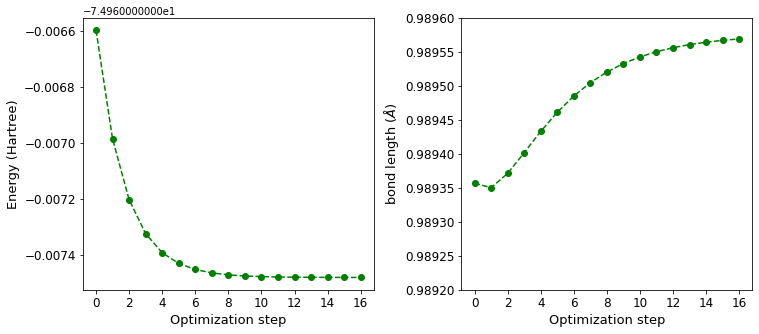

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

#Add energy plot on column 1
#E_fci = -74.9749
#E_vqe = np.array(energy)
#ax1 = fig.add_subplot(121)
#ax1.plot(range(n+1), E_vqe-E_fci, 'go-', ls='dashed')
#ax1.plot(range(n+1), np.full(n+1, 0.001), color='red')
#ax1.set_xlabel("Optimization step", fontsize=13)
#ax1.set_ylabel("$E_{VQE} - E_{FCI}$ (Hartree)", fontsize=13)
#ax1.text(5, 0.0013, r'Chemical accuracy', fontsize=13)
#plt.yscale("log")
#plt.xticks(fontsize=12)
#plt.yticks(fontsize=12)

ax1 = fig.add_subplot(121)
ax1.plot(range(n+1), energy, 'go-', ls='dashed')
#ax1.set_ylim([.98,1])
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
# ax2.text(5, 0.9865, r'Equilibrium bond length', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add bond length plot on column 2
d_fci = 0.96 # https://cccbdb.nist.gov/bondlengthmodel2.asp?method=12&basis=5
ax2 = fig.add_subplot(122)
ax2.plot(range(n+1), bond_length, 'go-', ls='dashed')
ax2.plot(range(n+1), np.full(n+1, d_fci), color='red')
ax2.set_ylim([.9892,.9896])
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("bond length ($\AA$)", fontsize=13)
# ax2.text(5, 0.9865, r'Equilibrium bond length', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()

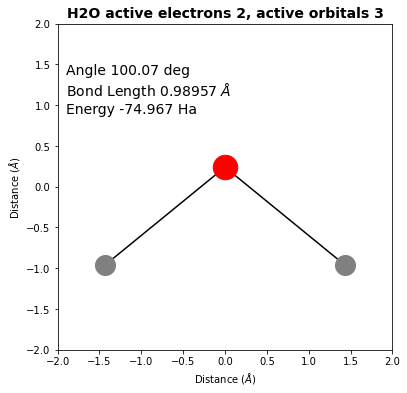

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
#ax = fig.add_subplot(111, projection='2d')


tensor = tf.constant(x)
arr = tensor.numpy()

h1 = np.array([arr[0], arr[1],arr[2]])
o1 = np.array([arr[3], arr[4],arr[5]])
h2 = np.array([arr[6], arr[7],arr[8]])


plt.plot( [h1[1],o1[1]] , [h1[2],o1[2]] ,color='black',zorder=1)
plt.plot( [h2[1],o1[1]] , [h2[2],o1[2]] ,color='black',zorder=1)
plt.scatter(h1[1],h1[2],color='grey',s=400,zorder=2,label = "Hydrogen")
plt.scatter(o1[1],o1[2],color='red',s=600,zorder=2, label = "Oxygen")
plt.scatter(h2[1],h2[2],color='grey',s=400,zorder=2)
 
h1o1 = h1 - o1
o1h2 = h2 - o1

cosine_angle = np.dot(h1o1, o1h2) / (np.linalg.norm(h1o1) * np.linalg.norm(o1h2))
angle = np.arccos(cosine_angle)

plt.title("H2O active electrons %.0f, active orbitals %.0f" 
          %(active_electrons,active_orbitals),fontsize=14,fontweight='bold')
plt.xlim([-2,2])
plt.ylim([-2,2])


plt.xlabel("Distance ($\AA$)")
plt.ylabel("Distance ($\AA$)")

#plt.legend(bbox_to_anchor=(1, 1),prop={'size': 15})
plt.annotate("Angle %.2f deg\nBond Length %.5f $\AA$\nEnergy %.3f Ha  " 
          %(np.degrees(angle),bond_length[-1],energy[-1]), xy =(-1.8, 1)
             ,xytext =(-1.9, .9),fontsize=14)

plt.show()